<a href="https://colab.research.google.com/github/baharehbehrouz/DL/blob/class/4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Download the dataset and extract
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

# Set dataset directory
data_dir = flowers_root


In [19]:
# Set image dimensions and batch size
img_height, img_width = 224, 224  # Standard size for MobileNetV2
batch_size = 32

# Load training data (80%) and validation data (20%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Optimize dataset loading for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [20]:
# Define data augmentation layers
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    layers.RandomRotation(0.2),  # Randomly rotate images
    layers.RandomZoom(0.2),  # Randomly zoom images
    layers.RandomContrast(0.2),  # Randomly adjust contrast
])


In [21]:
# Use MobileNetV2 as the base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,  # Exclude top dense layers
    weights='imagenet'  # Use pre-trained weights
)

# Freeze the base model layers
base_model.trainable = False

# Define the full model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))  # Input layer
x = data_augmentation(inputs)  # Apply data augmentation
x = layers.Rescaling(1./255)(x)  # Normalize the images
x = base_model(x)  # Pass through the base model
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
x = layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = layers.Dense(128, activation='relu')(x)  # Dense layer
x = layers.Dropout(0.3)(x)  # Another dropout layer
outputs = layers.Dense(5, activation='softmax')(x)  # Output layer (5 classes)

# Create the final model
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [22]:
# Compile the model with Adam optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [24]:
# Train the model with early stopping and checkpointing
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.2756 - loss: 1.9740 - val_accuracy: 0.6621 - val_loss: 1.0187
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.5044 - loss: 1.2484 - val_accuracy: 0.7398 - val_loss: 0.7977
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.5872 - loss: 1.0270 - val_accuracy: 0.7643 - val_loss: 0.6954
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.6701 - loss: 0.8629 - val_accuracy: 0.7929 - val_loss: 0.6155
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6674 - loss: 0.8604 - val_accuracy: 0.8038 - val_loss: 0.5755
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6874 - loss: 0.8001 - val_accuracy: 0.8229 - val_loss: 0.5476
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7276 - loss: 0.7271 - val_accuracy: 0.8283 - val_loss: 0.5202
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7262 - loss: 0.7153 - val_accuracy: 0.837

In [25]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.2f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8489 - loss: 0.4099
Validation Accuracy: 0.87


In [26]:
# Print the model summary
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_8 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,825 (10.50 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,228 (1.26 MB)

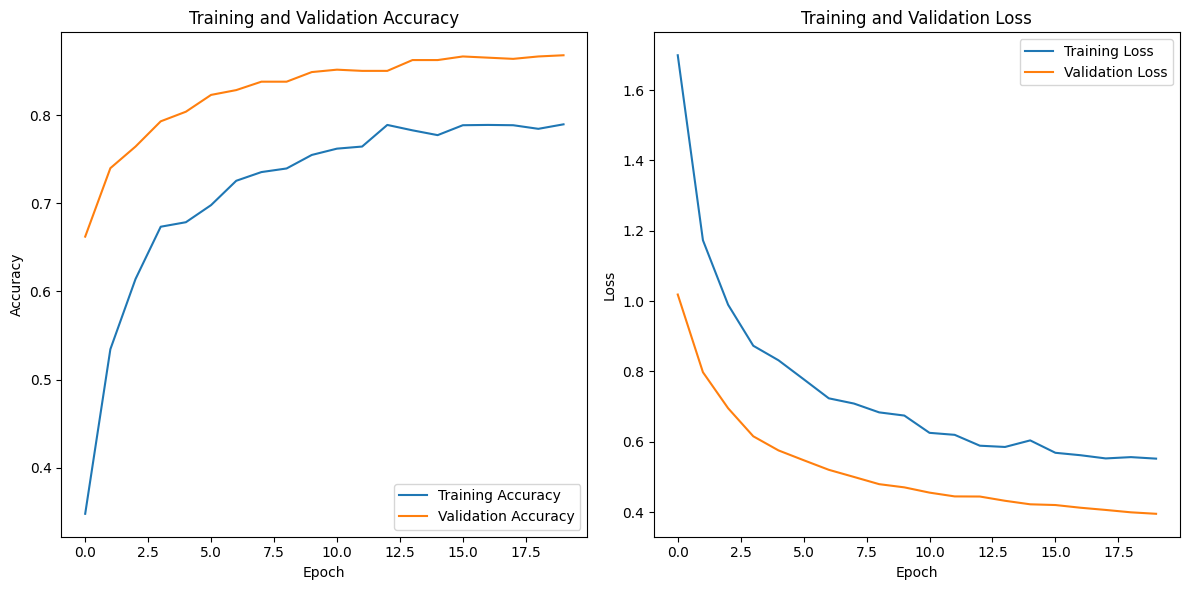

In [27]:
import matplotlib.pyplot as plt

# Plot the accuracy graph
plt.figure(figsize=(12, 6))

# Training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

